# Gaussian bump potential 4 - importance sampling

This is the fourth, and final, in a series of notebooks which will run importance sampling for the Gaussian bump potential. Familiarity with importance sampling is assumed

In this notebook we show how to run stochastic simulations and compare the different noise models.

We start as we did before by defining everything we need and loading in the required data

Throughout natural units with $c = 8\pi M_{\rm PL} = \hbar =1$ are used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mystyle
plt.style.use(mystyle.paper_style)

# Need to make sure you have pyfpt installed
import pyfpt as fpt
import multiprocessing as mp
from multiprocessing import Process, Queue
from timeit import default_timer as timer

from scipy.optimize import root
from scipy.integrate import trapezoid
from scipy.interpolate import CubicSpline

# Let us define the different colours used
color = ['#377eb8', '#ff7f00', '#984ea3','#4daf4a', '#a65628', '#f781bf','#999999', '#e41a1c', '#dede00']

## The potential
This is the [Gaussian bump potential](https://arxiv.org/abs/1911.00057).

In [2]:
def potential(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction = (phi**2)/(m_squared + phi**2)
    return V_0*fraction*(1 + K*expo)

def potential_functional_form(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction = (phi**2)/(m_squared + phi**2)
    return fraction*(1 + K*expo)

def potential_dif(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction1 = (phi**2)/(m_squared + phi**2)
    fraction2 = (phi)/(m_squared + phi**2) - (phi**3)/((m_squared + phi**2)**2)
    
    term1 = 2*V_0*fraction2*(1 + K*expo)
    term2 = V_0*fraction1*(-K*expo*(phi-phi_0)/(sigma_tilde**2))
    return term1 + term2

# I tested this against an interpolation of my previous derivative
def potential_ddif(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    square_brackets = 1 + K*expo
    overall_factor = 2*V_0/(m_squared + phi**2)
    
    term1 = -2*potential_dif(phi)*phi/(m_squared + phi**2)
    term2 = overall_factor*(1 - 3*(phi**2)/(m_squared + phi**2) + 2*(phi**4)/((m_squared + phi**2)**2))*\
        (1 + K*expo)
    term3 = overall_factor*(phi - (phi**3)/(m_squared + phi**2))*(-K*(phi-phi_0)*expo/(sigma_tilde**2))
    term4 = -overall_factor*0.5*phi*K*(3*phi - 2*phi_0)*expo/(sigma_tilde**2)
    term5 = overall_factor*0.5*K*expo*(phi*(phi-phi_0)/(sigma_tilde**2))**2
    
    return term1 + term2 + term3 + term4 + term5

def V_prime_by_V(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction3 = 1/phi - (phi)/(m_squared + phi**2)
    fraction4 = -(phi-phi_0)/(sigma_tilde**2)
    
    term1 = 2*fraction3
    term2 = fraction4*K*expo/(1 + K*expo)
    return term1 + term2

The parameters are shown such that the power spectrum peaks at $5 \times 10^{-3}$ in the astroid mass gap.

In [3]:
K = 1.17*(10**-3)  # This needs all 3 sig fig
cmb_power = 2*10**-9
cmb_phi = 3.0
phi_0 = 2.18812
m = 0.5
m_squared = m**2
sigma_tilde = 1.59*(10**-2)

V_0 = 12*(np.pi**2)*(cmb_power/potential_functional_form(cmb_phi))*(V_prime_by_V(cmb_phi)**2)


## Loading in background
We have already simulated the background, now we can just load it in.

In [4]:
background_data = pd.read_csv("gaussian_bump_dynamics_dynamics"+".csv", index_col=0)

N_values = np.array(background_data["N"])
phi_values = np.array(background_data["phi"])
phi_diff_values = np.array(background_data["phi_N_diff"])
hubble_param_values = np.array(background_data["H"])
epsilon1_values = np.array(background_data["epsilon1"])
epsilon2_values = np.array(background_data["epsilon2"])
nu_squared_values = np.array(background_data["nu_squared"])

Now let's interpolate over this data.

In [5]:
hubble_param_interpolation = CubicSpline(N_values, hubble_param_values)
epsilon1_interpolation = CubicSpline(N_values, epsilon1_values)
epsilon2_interpolation = CubicSpline(N_values, epsilon2_values)
nu_squared_interpolation = CubicSpline(N_values, nu_squared_values)

There are also a few constants and functions we need.

In [6]:
N_end = N_values[-1]

N_usr_start = 29.84178346243688
N_end_start = 32.25059795813168

N_sim_start = 31.13831633
N_sim_end = 39.1497714

a_in = 1.

dN = 0.00023659513392999544

analytical_fpt_std = 0.10104472578966923

N_sim_end_later = N_sim_end+2

In [7]:
def find_cg_time(k, sigma, N_exit):
    def exit_time_func(N_cg_exit):
        return k - sigma*aH_interpolation(N_cg_exit)
    N_guess = N_exit + np.log(sigma**-1)
    sol_cg_time = root(exit_time_func, N_guess)
    N_cg_exit = sol_cg_time.x
    return float(N_cg_exit)

# Importance sampling

Here we run simulations using importance sampling to investigate the far tail. As it is more straightforward to implement the 1D noise, that is what we do here. 

In [8]:
%load_ext cython

In [9]:
%%cython -a

import numpy as np

cdef double V_0 = 7.903587107979402e-11
cdef double e = 2.718281828459045
cdef double pi_num = 3.141592653589793
cdef double sigma_tilde = 1.59*(10**-2)
cdef double phi_0 = 2.18812
cdef double m_squared = 0.25
cdef double K = 1.17*(10**-3)
cdef double diff_const_squared = 6.351213422073874e-13
cdef double phi_end
cdef double expo
cdef double fraction
cdef double fraction3
cdef double fraction4
cdef double noise_value
cdef double bias_value
cdef double term1
cdef double term2
cdef double phi_old


cdef double V(double phi):
    expo = e**(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction = (phi**2)/(m_squared + phi**2)
    return V_0*fraction*(1 + K*expo)

cdef double V_prime_by_V_cython(double phi):
    expo = e**(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction3 = 1/phi - (phi)/(m_squared + phi**2)
    fraction4 = -(phi-phi_0)/(sigma_tilde**2)
    
    term1 = 2*fraction3
    term2 = fraction4*K*expo/(1 + K*expo)
    return term1 + term2
    
cdef int end_cond(double phi, double pi, double N, double phi_end):
    if phi<phi_end:
        return 1
    else:
        return 0


cdef list update(double phi, double pi, double A, double N, double dN, double [:] dW, double [:] noise,
                 double bias_amp):
    # Store old phi value to be used in calculating velocity
    phi_old = phi
    
    # Update field position
    phi = phi + (pi + bias_amp*noise[0])*dN + noise[0]*dW[0]

    # Update the velocity
    pi =\
        pi - (3 - 0.5*pi**2)*(pi + V_prime_by_V_cython(phi_old))*dN + bias_amp*noise[1]*dN + noise[1]*dW[0]

    if noise[0]>0:
        # Calculate the weight. This is the same as the true 1d case with diffusion based bias
        A += bias_amp*(0.5*bias_amp*dN + dW[0])

    return [phi, pi, A]


#A let's us calculate the bias w=e^-A is the bias, which propagated along with 
#the importance sample path.
#See Eq. (33) of arXiv:nucl-th/9809075v1 for more info
cdef list simulation_diff_general_end(double x_in, double y_in, double t_in, double t_f, double dt,
                                      double bias_amp, double phi_end_in, noise_list, rng):
    cdef double t, sqrt_dt, x, y, z, A
    cdef int i = 0
    cdef int end_cond_value
    cdef int len_rand_nums = 1000
    cdef int reduced_step = 0
    cdef int num_steps = 0
    
    cdef double [:, :] rand_nums
    cdef double [:] dW
    cdef double [:] noise

    t = t_in
    x = x_in
    y = y_in
    sqrt_dt = dt**0.5
    A = 0.0
    rand_nums = rng.normal(0, 1, size=(2, len_rand_nums))
    dW = rand_nums[:, 0]
    noise = noise_list[:, 0]

    while t<t_f:
        # Scale the step varaince to the dt used
        dW[0] = sqrt_dt*rand_nums[0, i]
        dW[1] = sqrt_dt*rand_nums[1, i]
        # Find the noise from the list provided
        noise[0] = noise_list[0, num_steps]
        noise[1] = noise_list[1, num_steps]
        # Define the Wiener step, using the pre-drawn random numbers.
        # Step in x and A simultanioues
        [x, y, A] =\
            update(x, y, A, t, dt, dW, noise, bias_amp)
        t += dt
        i += 1
        num_steps += 1
        # Using 1/0 for True/False
        end_cond_value = end_cond(x, y, t, phi_end_in)
        if end_cond_value == 1:
            break
        elif end_cond_value == -1 and reduced_step == 0:
            dt = dt/100
            sqrt_dt = dt**0.5
            reduced_step = 1
        elif end_cond_value == 0 and reduced_step == 1:
            dt = 100*dt
            sqrt_dt = dt**0.5
            reduced_step = 0
        # If all of the random numbers have been used up, need to update them.
        # This should still be more efficient than drawing a new random number
        # each time.
        if i == len_rand_nums:
            rand_nums = rng.normal(0, 1, size=(2, len_rand_nums))
            i = 0
    return [t, e**(-A)]


cpdef importance_sampling_simulations_2d_1d_noise(double x_in, double y_in, double t_in, double t_f,
                                                double dt, int num_runs, double bias_amp, double phi_end_in,
                                                noise_list):
    # As this variable is global, I can just redfine it hear
    rng = np.random.default_rng()
    results =\
        [simulation_diff_general_end(x_in, y_in, t_in, t_f, dt, bias_amp, phi_end_in, noise_list, rng)
         for i in range(num_runs)]

    ts, ws = [[results[i][j] for i in range(num_runs)] for j in range(2)]
    return ts, ws

In [10]:
def run_func_full_1D(N_exit, N_start, bias_amp, num_runs, noise_matrix, sigma, phi_in_post,
                                phi_deriv_in_post, phi_end, extra_label=None):

    start = timer()
    num_runs_per_core = int(num_runs/mp.cpu_count())

    # Using multiprocessing
    def multi_processing_func(x_in, y_in, t_i, t_f, dt, num_runs, bias_amp, phi_end, noise_matrix, queue_efolds,
                              queue_ws):
        results =\
            importance_sampling_simulations_2d_1d_noise(x_in, y_in, t_i, t_f, dt, num_runs, bias_amp, phi_end,
                                                      noise_matrix)
        fpt_values = np.array(results[0][:])
        ws = np.array(results[1][:])
        queue_efolds.put(fpt_values)
        queue_ws.put(ws)
    queue_efolds = Queue()
    queue_ws = Queue()
    cores = int(mp.cpu_count()/1)

    print('Number of cores used: '+str(cores))
    processes = [Process(target=multi_processing_func,
                         args=(phi_in_post, phi_deriv_in_post, N_start, 80., dN, num_runs_per_core, bias_amp,
                               phi_end, noise_matrix, queue_efolds, queue_ws))
                 for k in range(cores)]

    for p in processes:
        p.start()

    # More efficient to work with numpy arrays
    fpt_array = np.array([queue_efolds.get() for p in processes])
    ws_array = np.array([queue_ws.get() for p in processes])

    end = timer()
    print(f'The simulations took: {end - start} seconds')

    # Combine into columns into 1
    fpt_values = fpt_array.flatten()
    w_values = ws_array.flatten()

    # Sort in order of increasing Ns
    sort_idx = np.argsort(fpt_values)
    Ns = fpt_values[sort_idx]
    ws = w_values[sort_idx]
    if extra_label != None:
        extra_label = "_Gaussian_bump_sigma_"+str(sigma)+"_scale_exited"+str(round(N_exit, 5))\
            + "_1D_noise_" + extra_label
    else:
        extra_label = "_Gaussian_bump_sigma_"+str(sigma)+"_scale_exited"+str(round(N_exit, 5))\
        +"_1D_noise"

    fpt.numerics.save_data_to_file(Ns, ws, round(phi_in_post, 5), num_runs, bias_amp,
                      extra_label=extra_label)

To run the importance sampling simulations, all we have to do is add a bias to the simulations we run previously.

We will start with $\sigma=1$ before running the same set of simulations for $\sigma=0.01$.

Note that as we already an direct sampling in the last notebook, we don't need to simulate a bias amplitude of 0 here

In [11]:
num_runs = 10**5

sigma = 1.0

# load in the noise curve
noise_data = pd.read_csv("gaussian_bump_noise_curves_Bessel_matched_sigma_"+str(sigma)+"_1D.csv",
                             index_col=0)

N_cg_values = np.array(noise_data["N"])

noise_matrix_array = np.zeros((2, len(N_cg_values)))

noise_matrix_array[0, :] = np.array(noise_data["phi-phi noise"])
noise_matrix_array[1, :] = np.array(noise_data["pi-pi noise"])

# Need to add the zeros such there is enough noise to reach the end of the simulation
noise_matrix_array_with_zeros = np.zeros((2, len(noise_matrix_array[0,:])+int(4/dN)))

noise_matrix_array_with_zeros[:, :len(noise_matrix_array[0,:])] = noise_matrix_array
# Now need to find the correct start position and end value

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))

N_start_sigma_exit = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
N_end_sigma_exit = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

# Scales at the start and end
k_in_scale = aH_interpolation(N_sim_start)
k_end_scale = aH_interpolation(N_sim_end)

# This returns an array, so need to convert to a float
phi_with_scale_interpolation = CubicSpline(aH_interpolation(N_values), phi_values)
phi_diff_with_scale_interpolation = CubicSpline(aH_interpolation(N_values), phi_diff_values)
phi_in = float(phi_with_scale_interpolation(k_in_scale/sigma))
phi_deriv_in = float(phi_diff_with_scale_interpolation(k_in_scale/sigma))

# end value
k_end_scale_later = aH_interpolation(N_sim_end_later)
N_sim_end_later_sigma_exit = find_cg_time(aH_interpolation(N_sim_end_later), sigma, N_sim_end_later)
phi_end = float(phi_with_scale_interpolation(k_end_scale_later/sigma))

bias_amp_values = [1., 2.5]

for bias_amp in bias_amp_values:
    run_func_full_1D(N_sim_start, N_start_sigma_exit, bias_amp, num_runs, noise_matrix_array_with_zeros, sigma,
                                  phi_in, phi_deriv_in, phi_end, extra_label="bessel")

Number of cores used: 8
The simulations took: 500.53539138799533 seconds
Saved data to file IS_data_x_in_2.2_iterations_100000_bias_1.0_Gaussian_bump_sigma_1.0_scale_exited31.13832_1D_noise_bessel.csv
Number of cores used: 8
The simulations took: 508.3715310319094 seconds
Saved data to file IS_data_x_in_2.2_iterations_100000_bias_2.5_Gaussian_bump_sigma_1.0_scale_exited31.13832_1D_noise_bessel.csv


Now let's simulate for $\sigma=0.01$.

In [12]:
num_runs = 10**5

sigma = 0.01

# load in the noise curve
noise_data = pd.read_csv("gaussian_bump_noise_curves_Bessel_matched_sigma_"+str(sigma)+"_1D.csv",
                             index_col=0)

N_cg_values = np.array(noise_data["N"])

noise_matrix_array = np.zeros((2, len(N_cg_values)))

noise_matrix_array[0, :] = np.array(noise_data["phi-phi noise"])
noise_matrix_array[1, :] = np.array(noise_data["pi-pi noise"])

# Need to add the zeros such there is enough noise to reach the end of the simulation
noise_matrix_array_with_zeros = np.zeros((2, len(noise_matrix_array[0,:])+int(4/dN)))

noise_matrix_array_with_zeros[:, :len(noise_matrix_array[0,:])] = noise_matrix_array
# Now need to find the correct start position and end value

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))

N_start_sigma_exit = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
N_end_sigma_exit = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

# Scales at the start and end
k_in_scale = aH_interpolation(N_sim_start)
k_end_scale = aH_interpolation(N_sim_end)

# This returns an array, so need to convert to a float
phi_with_scale_interpolation = CubicSpline(aH_interpolation(N_values), phi_values)
phi_diff_with_scale_interpolation = CubicSpline(aH_interpolation(N_values), phi_diff_values)
phi_in = float(phi_with_scale_interpolation(k_in_scale/sigma))
phi_deriv_in = float(phi_diff_with_scale_interpolation(k_in_scale/sigma))

# end value
k_end_scale_later = aH_interpolation(N_sim_end_later)
N_sim_end_later_sigma_exit = find_cg_time(aH_interpolation(N_sim_end_later), sigma, N_sim_end_later)
phi_end = float(phi_with_scale_interpolation(k_end_scale_later/sigma))

bias_amp_values = [1., 2.5]

for bias_amp in bias_amp_values:
    run_func_full_1D(N_sim_start, N_start_sigma_exit, bias_amp, num_runs, noise_matrix_array_with_zeros, sigma,
                                  phi_in, phi_deriv_in, phi_end, extra_label="bessel")

Number of cores used: 8
The simulations took: 489.99275038100313 seconds
Saved data to file IS_data_x_in_2.2_iterations_100000_bias_1.0_Gaussian_bump_sigma_0.01_scale_exited31.13832_1D_noise_bessel.csv
Number of cores used: 8
The simulations took: 521.4909792159451 seconds
Saved data to file IS_data_x_in_2.2_iterations_100000_bias_2.5_Gaussian_bump_sigma_0.01_scale_exited31.13832_1D_noise_bessel.csv


We also want to compare against the classical $\delta \mathcal{N}$ prediction.

In [13]:
def classical_delta_N_generator(sigma_k, epsilon2):
    def pdf(deltaN):
        norm = 1/(2*np.pi*sigma_k**2)**0.5
        term1 = -2*( (1 - np.exp(-0.5*epsilon2*deltaN))/(sigma_k*epsilon2) )**2
        term2 = -0.5*epsilon2*deltaN
        return norm*np.exp(term1 + term2)
    return pdf

def gaussian_pdf_generator(std, mean=0):
    def pdf(x):
        expo_term = np.exp(-0.5*((x-mean)/std)**2)
        norm = 1/(std*(2*np.pi)**0.5)
        return norm*expo_term
    return pdf

Now we can compare the two choices of $\sigma$, as well as the Gaussian and classical $\delta \mathcal{N}$ predictions.

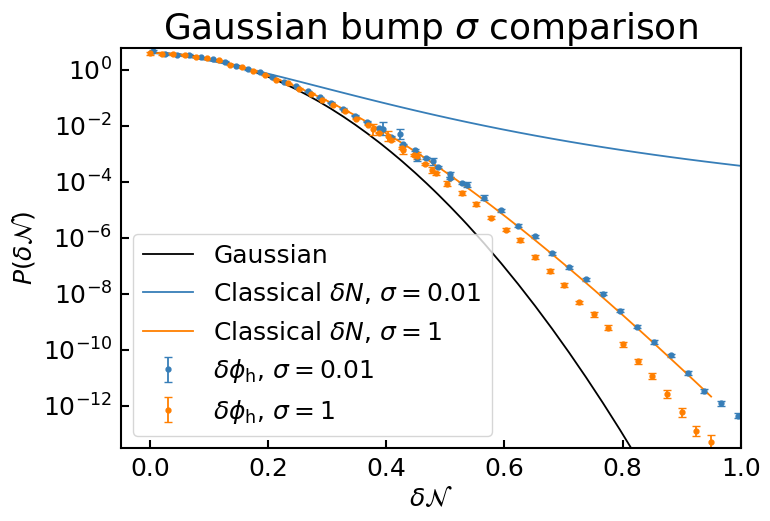

<Figure size 800x520 with 0 Axes>

In [14]:
sigma = 0.01

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))
k_in_scale = aH_interpolation(N_sim_start)
gaussian_pdf = gaussian_pdf_generator(analytical_fpt_std, mean=0)
epsilon2_sigma_001 = epsilon2_interpolation(find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end))
classical_delta_N_pdf_sigma_001 = classical_delta_N_generator(analytical_fpt_std, epsilon2_sigma_001)

for i in range(len(bias_amp_values)):
    # Very important to keep everything as Python objects
    bias_amp = bias_amp_values[i]
    base_file_name = "IS_data_x_in_2.2_iterations_100000_bias_"+str(bias_amp)+"_Gaussian_bump_sigma_"\
        +str(sigma)+"_scale_exited31.13832_1D_noise_bessel.csv"
    raw_data = pd.read_csv(base_file_name, index_col=0)

    # Easier to work with NumPy arrays
    Ns = np.array(raw_data['FPTs'])
    ws = np.array(raw_data['ws'])

    if bias_amp==0.:
        bin_centres, heights, errors = fpt.numerics.re_processing(Ns, estimator="naive",
                                                                  min_bin_size=100, t_f=65)
        peak_mean = np.mean(Ns)
        print(peak_mean)
    else:
        bin_centres, heights, errors = fpt.numerics.re_processing(Ns, weights=ws, estimator="lognormal",
                                                                  min_bin_size=500, t_f=65, display=False)
    bin_centres = np.array(bin_centres) - find_cg_time(k_end_scale_later, sigma, N_sim_end_later)
    if i == 0:
        bin_centres_combined = bin_centres
        bin_centres_combined = np.array(bin_centres_combined)
        heights_combined = heights
        heights_combined = np.array(heights_combined)
        errors_combined = errors
        errors_combined = np.array(errors_combined)
        plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7,
                     label=r"$\delta \phi_{\rm h}$, $\sigma = 0.01$",
                    color=color[0])
    else:
        bin_centres_combined = np.concatenate((bin_centres_combined, bin_centres))
        heights_combined = np.concatenate((heights_combined, heights))
        errors_combined = np.concatenate((errors_combined, errors), axis=1)
        plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7,
                    color=color[0])


sort_logic = np.argsort(bin_centres_combined)
bin_centres_combined = bin_centres_combined[sort_logic]
plt.plot(bin_centres_combined, gaussian_pdf(bin_centres_combined),
         color="k", label="Gaussian")
plt.plot(bin_centres_combined,
         classical_delta_N_pdf_sigma_001(bin_centres_combined),
         color=color[0], label="Classical $\delta N$, $\sigma=0.01$")

bin_centres_combined_001 = np.copy(bin_centres_combined)

#
#
#

sigma = 1.
epsilon2_sigma_1 = epsilon2_interpolation(find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end))
classical_delta_N_pdf_sigma_1 = classical_delta_N_generator(analytical_fpt_std, epsilon2_sigma_1)

for i in range(len(bias_amp_values)):
    # Very important to keep everything as Python objects
    bias_amp = bias_amp_values[i]
    base_file_name = "IS_data_x_in_2.2_iterations_100000_bias_"+str(bias_amp)+"_Gaussian_bump_sigma_"\
        +str(sigma)+"_scale_exited31.13832_1D_noise_bessel.csv"
    raw_data = pd.read_csv(base_file_name, index_col=0)

    # Easier to work with NumPy arrays
    Ns = np.array(raw_data['FPTs'])
    ws = np.array(raw_data['ws'])

    if bias_amp==0.:
        bin_centres, heights, errors = fpt.numerics.re_processing(Ns, estimator="naive",
                                                                  min_bin_size=100, t_f=65)
        peak_mean = np.mean(Ns)
        print(peak_mean)
    else:
        bin_centres, heights, errors = fpt.numerics.re_processing(Ns, weights=ws, estimator="lognormal",
                                                                  min_bin_size=500, t_f=65, display=False)
    bin_centres = np.array(bin_centres) - find_cg_time(k_end_scale_later, sigma, N_sim_end_later)
    if i == 0:
        bin_centres_combined = bin_centres
        bin_centres_combined = np.array(bin_centres_combined)
        heights_combined = heights
        heights_combined = np.array(heights_combined)
        errors_combined = errors
        errors_combined = np.array(errors_combined)
        plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7,
                     label=r"$\delta \phi_{\rm h}$, $\sigma = 1$",
                    color=color[1])
    else:
        bin_centres_combined = np.concatenate((bin_centres_combined, bin_centres))
        heights_combined = np.concatenate((heights_combined, heights))
        errors_combined = np.concatenate((errors_combined, errors), axis=1)
        plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7,
                    color=color[1])


# Need to use log scale to see data in the far tail
sort_logic = np.argsort(bin_centres_combined)
bin_centres_combined = bin_centres_combined[sort_logic]
plt.plot(bin_centres_combined,
         classical_delta_N_pdf_sigma_1(bin_centres_combined),
         color=color[1], label="Classical $\delta N$, $\sigma=1$")
plt.yscale('log')
plt.legend(fontsize=18)
plt.xlabel(r'$\delta \mathcal{N}$')
plt.ylabel(r'$P(\delta \mathcal{N})$')
plt.ylim(bottom = 0.6*np.min(heights_combined), top = 1.6*np.max(heights_combined))
plt.title(r"Gaussian bump $\sigma$ comparison")
plt.xlim(left = np.min(bin_centres_combined)-0.05, right=np.max(bin_centres_combined)+0.05)
plt.show()
plt.clf()

The tails for the $\sigma=1$ and $\sigma=0.01$ clearly deviate, nand the classical $\delta \mathcal{N}$ does not agree, but there is coincident agreement for the numeriical with $\sigma=0.01$ and the classical $\delta \mathcal{N}$ for $\sigma=1. Both data sets show clear non-Gaussianity in the tail.